In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
from time import time
from datetime import date, datetime, timedelta

from scipy.optimize import minimize
from scipy.stats import norm

plt.rcParams["font.family"] = 'Arial'

### BS Greeks

In [2]:
def calc_delta_BS(St, K, r, sigma, T, q = 0, _type = None):
    # time_diff : (days)
    if _type == "C":  # call
        w = 1
    if _type == "P":  # put
        w = -1
    
    moneyness = K/St
    d1 = ( - np.log(moneyness) + (r - q + 0.5*sigma**2) * (T) ) / ( sigma * np.sqrt(T) )
    d2 = d1 - sigma * np.sqrt(T)
    d3 = d2 - sigma * np.sqrt(T)
    return w * np.exp( sigma**2 * (T) ) * ( 1 / St**2 ) * K * norm.cdf(w*d3)
    

def calc_gamma_BS(St, K, r, sigma, T, q = 0, _type = None):
    # time_diff : (days)
    if _type == "C":  # call
        w = 1
    if _type == "P":  # put
        w = -1
    
    moneyness = K/St
    d1 = ( - np.log(moneyness) + (r - q + 0.5*sigma**2) * (T) ) / ( sigma * np.sqrt(T) )
    d2 = d1 - sigma * np.sqrt(T)
    d3 = d2 - sigma * np.sqrt(T)
    return np.exp( sigma**2 * (T) ) * ( 1 / St**3 ) * K  \
            * ( norm.pdf(w*d3) / ( sigma * np.sqrt(T) )  - 2 * w * norm.cdf(w*d3) )
    

def calc_vega_BS(St, K, r, sigma, T, q = 0, _type = None):
    # time_diff : (days)
    if _type == "C":  # call
        w = 1
    
    if _type == "P":  # put
        w = -1

    moneyness = K/St
    d1 = ( - np.log(moneyness) + (r - q + 0.5*sigma**2) * T ) / ( sigma * np.sqrt(T) )
    d2 = d1 - sigma * np.sqrt(T)
    d3 = d2 - sigma * np.sqrt(T)
    return norm.pdf(d2) * np.sqrt(T) - 2 * w * np.exp( sigma**2 * T ) * sigma * T * moneyness * norm.cdf(w*d3)

### SV Greeks

In [3]:
N = 10**4
Z_y = np.random.normal(0, 1, (300,N) )
Z_x = np.random.normal(0, 1, (300,N) )

In [21]:
# Calculate price by Monte Carlo

def generate_g_MC(T, rho, alpha, beta, V0, sigma_v, N):
    mu = 0
    # parameters: mu, rho, alpha, beta, V0, sigma_v

    Y = Z_y[:T,:N]
    X = rho * Z_y[:T,:N] + np.sqrt(1 - rho**2) * Z_x[:T,:N]
    
    g_list = np.array([]) # shock list

    for n in range(N):
        
        vol = V0
        log_g = 0
        neg_vol = False
        
        ### Construct a single path
        for t in range(T):
            # Votatility process
            Yt = Y[t, n]
            new_vol = alpha + beta*vol + sigma_v * np.sqrt(vol) * Yt
            
            # Check if there is negative volatility
            if new_vol < 0:
                neg_vol = True
                break
            
            # Shock process
            Xt = X[t, n]
            temp = ( mu - new_vol/2 ) + np.sqrt(new_vol) * Xt
            log_g = log_g + temp
            vol = new_vol

        if neg_vol == False:
            g = np.exp( log_g )
            g_list = np.append( g_list, g )

    
    return g_list


def calc_price_SV(S0_list, K, T, rho, alpha, beta, V0, sigma_v, _type = None, N = 100):
    # Note: S0_list should be an np.array
    g = generate_g_MC(T, rho, alpha, beta, V0, sigma_v, N)
    ST_s = g.reshape(-1, 1) @ S0_list.reshape(1, -1)
        # If there are m different S0, the shape would be an N x m matrix, with each row is a bunch of simulated prices for one S0
    
    if _type == "C":
        w = 1
    if _type == "P":
        w = -1
    
    payoffs = w*(1 - K/ST_s) * (  w*(1 - K/ST_s) > 0)
    return payoffs.mean(axis=0)  # shape would be 1D-array, with shape M

In [26]:
def calc_delta_MC(S0_list, K, T, rho, alpha, beta, V0, sigma_v, _type = None, N = 100):
    # Note: S0_list should be an np.array, let size = m
    g = generate_g_MC(T, rho, alpha, beta, V0, sigma_v, N)
    ST_s = g.reshape(-1, 1) @ S0_list.reshape(1, -1)  # shape = len(g) x m
    
    if _type == "C":
        w = 1
    if _type == "P":
        w = -1
    
    temp = np.tile(S0_list, ( len(g), 1) )
    delta_list = w * ( K / ST_s / temp) * (  w*(ST_s - K) > 0 )
    delta = np.mean( delta_list, axis = 0)
    
    return delta

def calc_gamma_MC(S0_list, K, T, rho, alpha, beta, V0, sigma_v, _type = None, N = 100):
    mu = 0
    # Note: S0_list should be an np.array, let size = m
    
    ###### Generate g, h, and V_{T}
    
    Y = Z_y[:T,:N]
    X = rho * Z_y[:T,:N] + np.sqrt(1 - rho**2) * Z_x[:T,:N]

    g_list = np.array([]) # shock list
    h_list = np.array([])
    VT_list = np.array([])
    Y_idx_list = np.array([])

    for n in range(N):
        
        vol = V0
        log_g = 0
        neg_vol = False
        
        ### Construct a single path
        for t in range(T):
            # Votatility process
            Yt = Y[t, n]
            new_vol = alpha + beta*vol + sigma_v * np.sqrt(vol) * Yt
            
            # Check if there is negative volatility
            if new_vol < 0:
                neg_vol = True
                break
            
            # Shock process
            Xt = X[t, n]
            temp = ( mu - new_vol/2 ) + np.sqrt(new_vol) * Xt
            log_g = log_g + temp
            vol = new_vol

        if neg_vol == False:
            g = np.exp( log_g )
            g_list = np.append( g_list, g )

            h = np.exp( log_g - temp )
            h_list = np.append( h_list, h )

            VT_list = np.append( VT_list, new_vol)

            Y_idx_list = np.append( Y_idx_list, n).astype(int)
    
    ST_list = g_list.reshape(-1, 1) @ S0_list.reshape(1, -1)  # shape = len(g) x m
    
    ###### Estimate gamma by the formula
    if _type == "C":
        w = 1
    if _type == "P":
        w = -1
    
    temp_1 = h_list.reshape(-1, 1) @ S0_list.reshape(1, -1) # S0*h
    temp_2 = np.tile( VT_list.reshape(-1, 1), len(S0_list)  ) # V_{T}

    temp_3 = np.tile( Y[T-1, Y_idx_list ].reshape(-1, 1), len(S0_list) ) # Z_{Y, T} 
    temp_4 = np.tile(S0_list, ( len(g_list), 1) )   # S0
        # for temp_1 ~ temp_4, all have shape = len(g) x m
    
    temp_5 = np.tile( (mu - VT_list/2).reshape(-1,1) , (1, len(S0_list)) )
    chi_list = (   ( np.log(K / temp_1) - temp_5  ) / np.sqrt(temp_2) - rho * temp_3  ) / np.sqrt(1-rho**2)
    partial_chi_list = - 1 / temp_4 / np.sqrt( (1-rho**2)*temp_2 )
        # both are shape = N x m
    
    gamma_pt_1_list = w * ( -2 * K / ST_list / (temp_4**2) ) * (  w*(ST_list - K) > 0 )
    gamma_pt_2_list = 1 / temp_4 * norm.pdf(chi_list) * partial_chi_list
    
    gamma_list = gamma_pt_1_list - gamma_pt_2_list  # shape = len(g) x m
    gamma = np.mean( gamma_list, axis = 0 )
    
    return gamma

def calc_vega_MC(S0_list, K, T, rho, alpha, beta, V0, sigma_v, _type = None, N = 100):
    # Note: S0_list should be an np.array, let size = m
    mu = 0
    
    Y = Z_y[:T,:N]
    X = rho * Z_y[:T,:N] + np.sqrt(1 - rho**2) * Z_x[:T,:N]

    ## Generate shock g(Zx, Zy) 

    g_list = np.array([]) # shock list
    VT_list = np.array([])
    Y_idx_list = np.array([])

    for n in range(N):
        
        vol = V0
        log_g = 0
        neg_vol = False
        
        ### Construct a single path
        for t in range(T):
            # Votatility process
            Yt = Y[t, n]
            new_vol = alpha + beta*vol + sigma_v * np.sqrt(vol) * Yt
            
            # Check if there is negative volatility
            if new_vol < 0:
                neg_vol = True
                break
            
            # Shock process
            Xt = X[t, n]
            temp = ( mu - new_vol/2 ) + np.sqrt(new_vol) * Xt
            log_g = log_g + temp
            vol = new_vol

        if neg_vol == False:
            g = np.exp( log_g )
            g_list = np.append( g_list, g )

            VT_list = np.append( VT_list, new_vol)
            Y_idx_list = np.append( Y_idx_list, n ).astype(int)
    
    # Construct the function G(.) , and partial_g / g
    V = np.full( (T+1, N), V0 )
    vol = np.ones(N) * V0
    for t in range(1, T+1):
        Yt = Y[t-1, :N ]
        new_vol = alpha + beta*vol + sigma_v * np.sqrt(vol) * Yt
        
        vol = new_vol
        V[t,:] = new_vol

    _V = V[:, ~(V<0).any(axis = 0) ]
    V_hat = _V[:T]

    G = beta + 1 / (2* np.sqrt(V_hat)) * Y[:, Y_idx_list ] * sigma_v 
    temp_G = np.cumprod(G, axis = 0) * (  X[:, Y_idx_list ] / ( 2*np.sqrt( _V[1:] ) ) - 0.5  )
    temp_G = np.sum(temp_G, axis = 0).reshape(-1, 1)  # shape = N x 1 , this is partial_g / g
    temp_G = np.tile( temp_G, len(S0_list) ) # shape = len(g) x m
    

    ST_list = g_list.reshape(-1, 1) @ S0_list.reshape(1, -1)  # shape = len(g) x m
    
    ###### Estimate vega by the formula
    if _type == "C":
        w = 1
    if _type == "P":
        w = -1
    
    vega_list = w * ( K * 2 *np.sqrt(V0) ) * (temp_G / ST_list) * (  w*(ST_list - K) > 0 ) # shape = N x m
    vega = np.mean(vega_list, axis = 0)
    
    return vega

In [23]:
# BS parameter
sigma = 0.0348

# SV parameters
rho, alpha, beta, V0, sigma_v = [0.2252, 0.00124, 0.4120, 0.0001, 0.0194]

## Delta

Time consumption: 13.6887 secs.


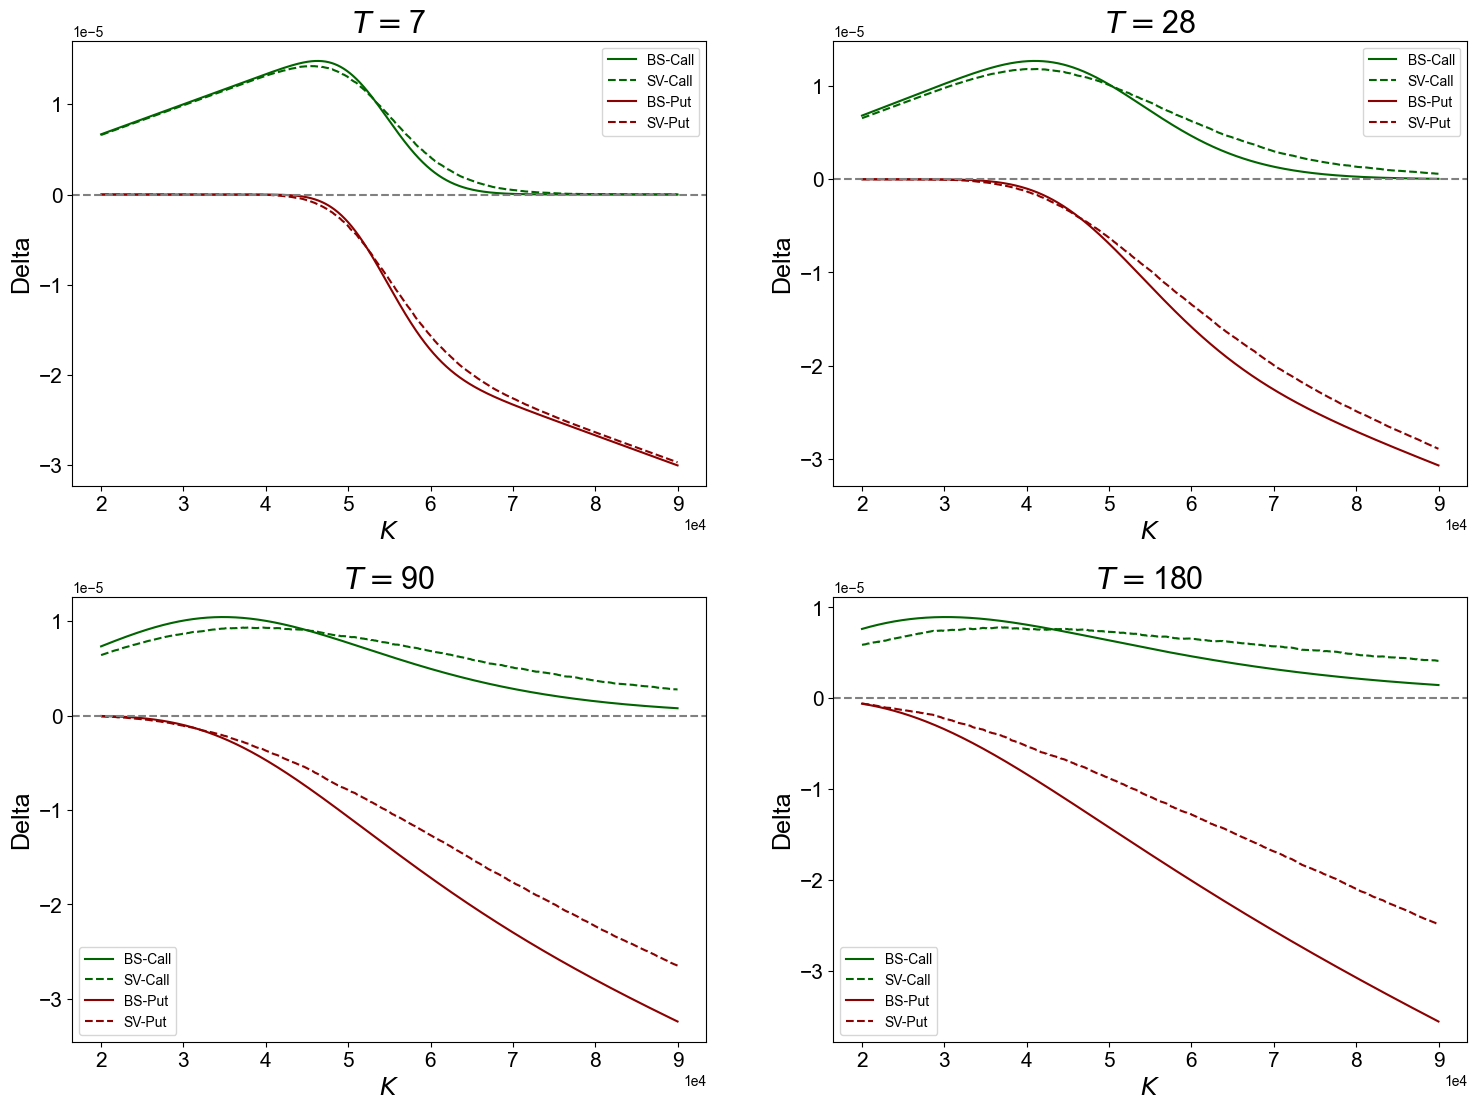

In [24]:
S0_list = np.array([55000], dtype = float);  
m = len(S0_list)
K_list = np.arange(20000, 90000, 10);  tau = 7; _type = "C"
r = 0

start = time()
tau_list = [7, 28, 90, 180]

fig, axes = plt.subplots( 2, 2, figsize = (18, 13) )
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for i, ax in enumerate(axes.flat):
    tau = tau_list[i]
    delta_call_BS = np.array([]); delta_put_BS = np.array([])
    
    for K in K_list:
        _delta_BS = calc_delta_BS(S0_list, K, 0, sigma, tau, _type = "C")
        delta_call_BS = np.append(delta_call_BS, _delta_BS)
    
        _delta_BS = calc_delta_BS(S0_list, K, 0, sigma, tau, _type = "P")
        delta_put_BS = np.append(delta_put_BS, _delta_BS)

    delta_call_MC = calc_delta_MC(S0_list, K_list, tau, rho, alpha, beta, V0, sigma_v, "C", N)
    delta_put_MC = calc_delta_MC(S0_list, K_list, tau, rho, alpha, beta, V0, sigma_v, "P", N)

    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    ax.plot(K_list, delta_call_BS, label = "BS-Call", color = "darkgreen")
    ax.plot(K_list, delta_call_MC, label = "SV-Call", color = "darkgreen", linestyle = "--")
    ax.plot(K_list, delta_put_BS, label = "BS-Put", color = "darkred")
    ax.plot(K_list, delta_put_MC, label = "SV-Put", color = "darkred", linestyle = "--")
    ax.axhline( linestyle = "--", color = "gray")
    ax.legend()

    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.set_title("$T = $" + str(tau), fontsize = 22)
    ax.set_xlabel("$K$", fontsize = 18)
    ax.set_ylabel("Delta", fontsize = 18)

end = time()
print(f"Time consumption: {end-start:.4f} secs.")

## Gamma

Time consumption: 36.4638 secs.


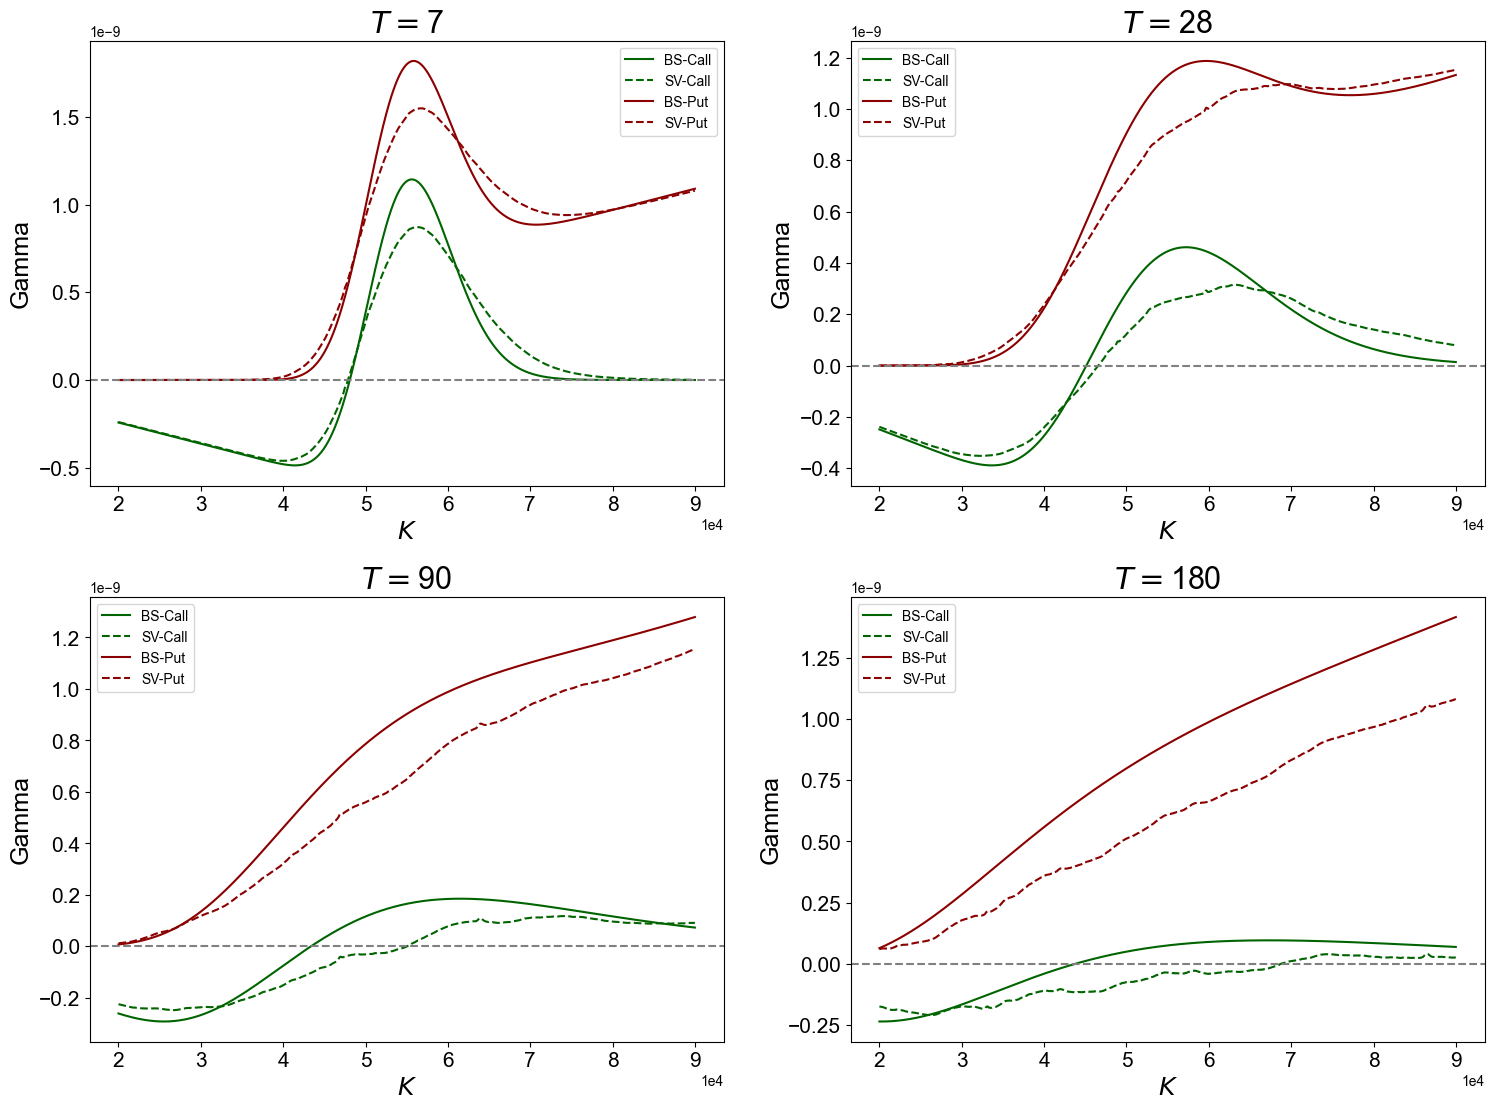

In [25]:
S0_list = np.array([55000], dtype = float);  
m = len(S0_list)
K_list = np.arange(20000, 90000, 10)
r = 0

start = time()
tau_list = [7, 28, 90, 180]

fig, axes = plt.subplots( 2, 2, figsize = (18, 13) )
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for i, ax in enumerate(axes.flat):
    tau = tau_list[i]
    gamma_call_BS = np.array([]); gamma_put_BS = np.array([])
    
    for K in K_list:
        _gamma_BS = calc_gamma_BS(S0_list, K, r, sigma, tau, _type = "C")
        gamma_call_BS = np.append(gamma_call_BS, _gamma_BS)
    
        _gamma_BS = calc_gamma_BS(S0_list, K, r, sigma, tau, _type = "P")
        gamma_put_BS = np.append(gamma_put_BS, _gamma_BS)

    gamma_call_MC = calc_gamma_MC(S0_list, K_list, tau, rho, alpha, beta, V0, sigma_v, "C", N)
    gamma_put_MC = calc_gamma_MC(S0_list, K_list, tau, rho, alpha, beta, V0, sigma_v, "P", N)

    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    ax.plot(K_list, gamma_call_BS, label = "BS-Call", color = "darkgreen")
    ax.plot(K_list, gamma_call_MC, label = "SV-Call", color = "darkgreen", linestyle = "--")
    ax.plot(K_list, gamma_put_BS, label = "BS-Put", color = "darkred")
    ax.plot(K_list, gamma_put_MC, label = "SV-Put", color = "darkred", linestyle = "--")
    ax.axhline( linestyle = "--", color = "gray")
    ax.legend()

    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.set_title("$T = $" + str(tau), fontsize = 22)
    ax.set_xlabel("$K$", fontsize = 18)
    ax.set_ylabel("Gamma", fontsize = 18)
    
end = time()
print(f"Time consumption: {end-start:.4f} secs.")

## Vega

C:\Users\user\AppData\Local\Temp\ipykernel_22716\3422515014.py:141: RuntimeWarning: invalid value encountered in sqrt
  new_vol = alpha + beta*vol + sigma_v * np.sqrt(vol) * Yt


Time consumption: 15.7405 secs.


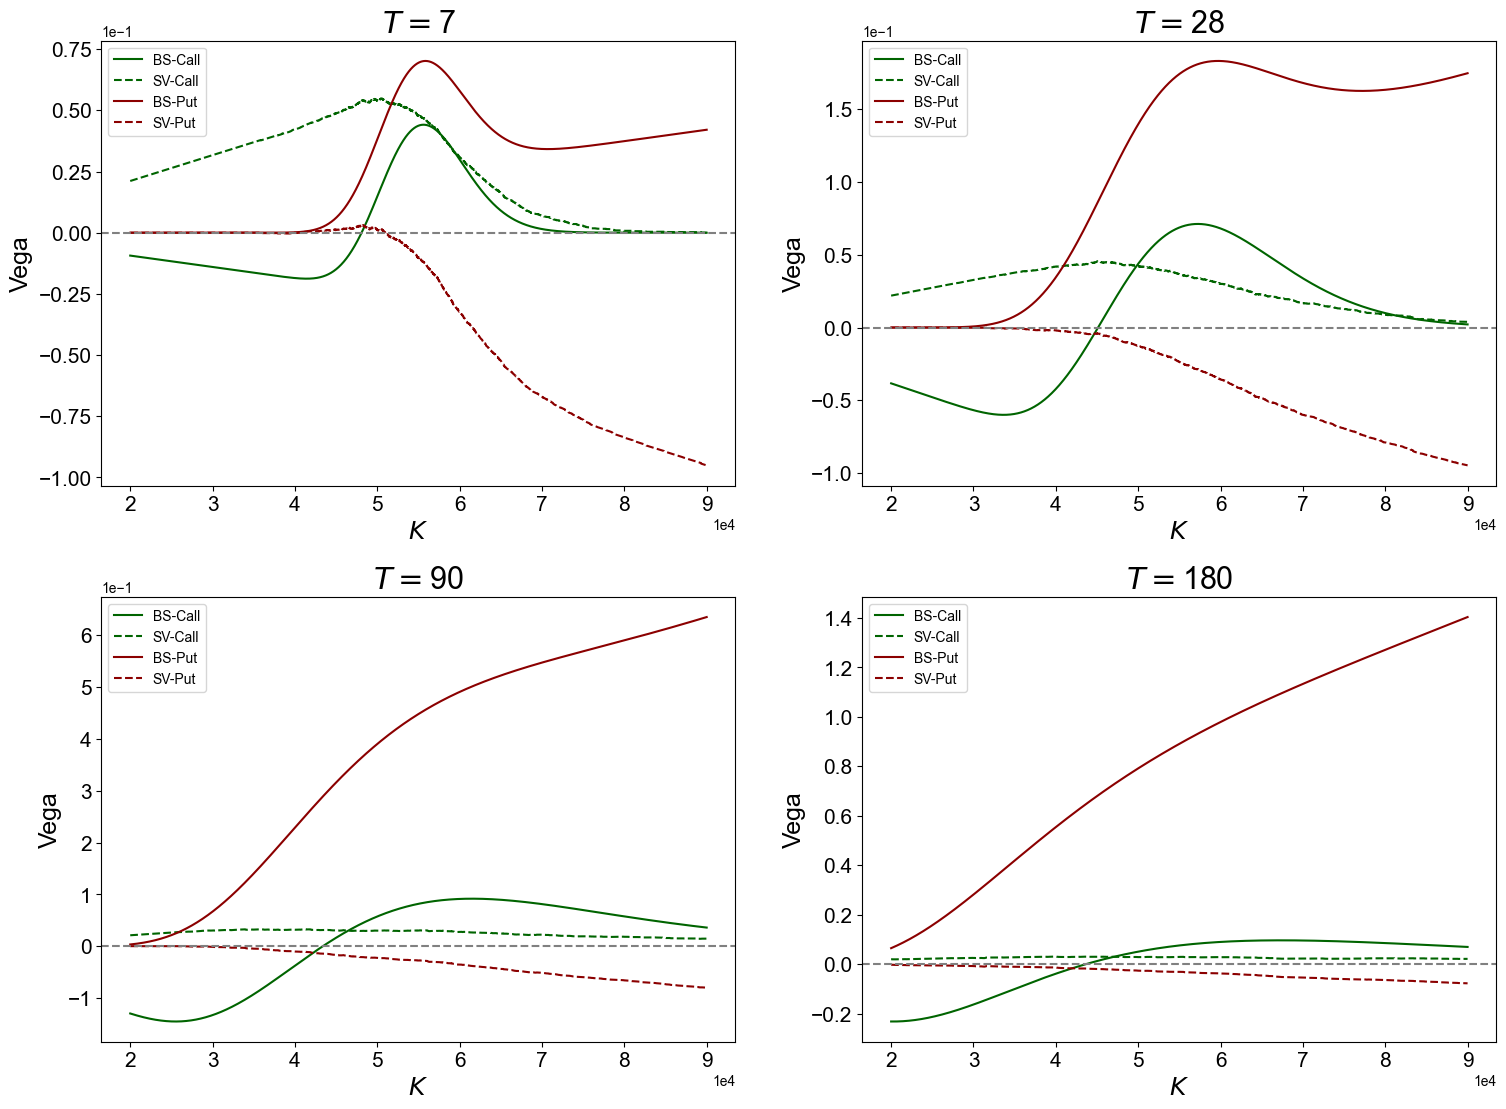

In [27]:
S0_list = np.array([55000], dtype = float);  
m = len(S0_list)
K_list = np.arange(20000, 90000, 10);  tau = 7; _type = "C"
r = 0

start = time()
tau_list = [7, 28, 90, 180]

fig, axes = plt.subplots( 2, 2, figsize = (18, 13) )
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for i, ax in enumerate(axes.flat):
    tau = tau_list[i]
    vega_call_BS = np.array([]); vega_put_BS = np.array([])
    
    for K in K_list:
        _vega_BS = calc_vega_BS(S0_list, K, 0, sigma, tau, _type = "C") / np.sqrt(365)
        vega_call_BS = np.append(vega_call_BS, _vega_BS)
    
        _vega_BS = calc_vega_BS(S0_list, K, 0, sigma, tau, _type = "P") / np.sqrt(365)
        vega_put_BS = np.append(vega_put_BS, _vega_BS)

    vega_call_MC = calc_vega_MC(S0_list, K_list, tau, rho, alpha, beta, V0, sigma_v, "C", N)
    vega_put_MC = calc_vega_MC(S0_list, K_list, tau, rho, alpha, beta, V0, sigma_v, "P", N)

    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    ax.plot(K_list, vega_call_BS, label = "BS-Call", color = "darkgreen")
    ax.plot(K_list, vega_call_MC, label = "SV-Call", color = "darkgreen", linestyle = "--")
    ax.plot(K_list, vega_put_BS, label = "BS-Put", color = "darkred")
    ax.plot(K_list, vega_put_MC, label = "SV-Put", color = "darkred", linestyle = "--")
    ax.axhline( linestyle = "--", color = "gray")
    ax.legend()

    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.set_title("$T = $" + str(tau), fontsize = 22)
    ax.set_xlabel("$K$", fontsize = 18)
    ax.set_ylabel("Vega", fontsize = 18)

end = time()
print(f"Time consumption: {end-start:.4f} secs.")